Проект выполняют: Торова Анна, Дерюгин Тимофей, Парамонов Михаил.

Мы исследуем зависимость социально-экономических показателей и показателей рождаемости для субъектов России в период с 2013 по 2022 годы.

В качестве социально-экономических показателей мы выбрали реальную среднемесячную заработную плату для субъекта, регион, показатели безработицы, а также доля людей, находящихся за чертой бедности.

Все данные были взяты с сайта Росстата. 

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import requests
from bs4 import BeautifulSoup

Для начала подгрузим скачанные файлы в формате DataFrame и немного их подкорректируем. Nan заменим на средние значения по субъекту.

In [166]:
poverty_df = pd.read_excel('Data_for_project/bednost-2013-2022 (1).xlsx')
unemployment_df = pd.read_excel('Data_for_project/bezraboticca.xlsx')
fertility_df = pd.read_excel('Data_for_project/fertility.xlsx')
income_df = pd.read_excel('Data_for_project/zarplata.xlsx')

poverty_df.columns = ['subject'] + [int(x) for x in poverty_df.loc[1][1:].tolist()]
poverty_df.drop(labels=[0, 1], axis=0, inplace=True)
poverty_df.set_index(poverty_df['subject'], inplace=True)
poverty_df.drop(labels=['subject'], axis=1, inplace=True)
poverty_df = poverty_df.fillna(poverty_df.mean(axis=1), axis=0)

unemployment_df.set_index(unemployment_df['subject'], inplace=True)
unemployment_df.drop(labels=['subject'], axis=1, inplace=True)
unemployment_df = unemployment_df.fillna(unemployment_df.mean(axis=1), axis=0)

fertility_df.columns = ['subject'] + [int(x) for x in fertility_df.loc[0][1:].tolist()]
fertility_df.drop(labels=[0], axis=0, inplace=True)
fertility_df.set_index(fertility_df['subject'], inplace=True)
fertility_df.drop(labels=['subject'], axis=1, inplace=True)
fertility_df = fertility_df.fillna(fertility_df.mean(axis=1), axis=0)

income_df.set_index(income_df['subject'], inplace=True)
income_df.drop(labels=['subject'], axis=1, inplace=True)
income_df = income_df.fillna(income_df.mean(axis=1), axis=0)


Сведения о среднемесячных зарплатах приведены в номинальном выражении. Возьмем данные об инфляции за 2013-2022 годы и посчитаем зарплаты в реальном выражении по отношению к 2013 году. 

In [138]:
#Здесь мы воспользовались помощью Chatgpt. Запрос был задан так: спарси по ссылке (...) инфляцию с 2013 по 2022 год на питоне
response = requests.get('https://infotables.ru/statistika/79-ekonomicheskaya-statistika-rossii/1321-inflyatsiya-v-rossii-tablitsa')

soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table')

inflation_arr = np.array([])
data_rows_raw= table.tbody.find_all('tr')

for row in data_rows_raw[1:]:
    cols=row.find_all('td')
    cols=[x.text.strip() for x in cols]
    
    year=int(cols[0])
    
    if year>=2013 and year<=2022:        
        inflation=float(cols[1].replace(',','.'))
        inflation_arr = np.append(inflation_arr, inflation)
        
inflation_arr = inflation_arr[::-1]
print(inflation_arr)

[ 6.45 11.36 12.91  5.38  2.52  4.27  3.05  4.91  8.39 10.65]


Далее считаем индекс-дефлятор, который показывает цену рубля в реальном выражении на определенный год по отношению к базовому году. Домножаем значение зарплаты каждого года на соответствующий коэффициент

In [139]:
index_deflator = np.array([1])

for i in range(9):
    index_deflator = np.append(index_deflator, index_deflator[-1]/(1+inflation_arr[i]/100))

income_df = income_df.mul(index_deflator, axis=1)
income_df.head()

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
subject,,,,,,,,,,
Белгородская область,20381.2,21097.980272,20099.251983,18255.004393,19532.726326,20260.923148,21129.296974,22906.242426,23190.776212,24812.928957
Брянская область,16773.9,17740.347581,16676.688370,15621.691040,16048.058374,16981.636339,17792.104319,18967.130241,19163.820579,20389.736209
Владимирская область,18379.5,19419.915453,18750.539890,17246.312242,17498.552797,19321.137931,20706.220241,20777.394413,20740.714100,21165.035883
Воронежская область,19667.8,20389.948333,19483.440232,17710.052127,17963.387906,19343.633398,20171.521289,21081.239728,21484.744780,22942.655746
Ивановская область,16529.6,17727.383748,17079.749815,14920.813988,14516.620331,16113.258036,16389.232546,17001.307049,16711.733977,17479.504155


Из текущих "сырых" таблиц теперь надо сделать одну большую. Ее колонками будут: год, регион, реальная зарплата, доля людей за чертой бедности, безработица и, конечно, рождаемость

In [140]:
#Здесь мы опять воспользовались помощью Chatgpt. Необходимо было из датафрейма 82*10 (субъектов*количество лет) 
#получить датафрейм (2*820), где одним столбцом будут год+регион, а вторым - признак (безработица или зарплата итд)
#Запросов было много, потому что он постоянно разделял год и регион и в новом датафрейме получалось много столбцов
#Итоговый запрос был таким: Есть датафрейм, столбцы - годы, индексы - субъекты РФ. Значениями таблицы является зарплата. 
#Необходимо создать датафрейм с двумя 
#колонками, в первой будет указана зарплата, во второй - вместе Субъект РФ и год

def df_remake(df, priznak):
    df_stacked = df.stack()
    df_stacked = df_stacked.reset_index()
    df_stacked = df_stacked.rename(columns={'level_0': 'subject', 'level_1': 'Year', 0: priznak})
    df_stacked['Subject and year'] = df_stacked['subject'] + ', ' + df_stacked['Year'].astype(str)
    df_result = df_stacked[[priznak, 'Subject and year']].set_index('Subject and year')

    return df_result

income_df = df_remake(income_df, 'income')
unemployment_df = df_remake(unemployment_df, 'unemployment')
fertility_df = df_remake(fertility_df, 'fertility')
poverty_df = df_remake(poverty_df, 'poverty')

new_df = income_df.merge(unemployment_df, left_index=True, right_index=True)\
               .merge(fertility_df, left_index=True, right_index=True)\
               .merge(poverty_df, left_index=True, right_index=True)

new_df.head()


,income,unemployment,fertility,poverty
Subject and year,,,,
"Белгородская область, 2013",20381.200000,4.0,1.526,0.075979
"Белгородская область, 2014",21097.980272,4.0,1.544,0.077480
"Белгородская область, 2015",20099.251983,4.1,1.561,0.085901
"Белгородская область, 2016",18255.004393,4.0,1.547,0.081919
"Белгородская область, 2017",19532.726326,3.9,1.389,0.078786


Мы получили таблицу с 4 признаками для каждого региона и года. Теперь проведем EDA анализ

In [159]:
def EDA(df, priznak):
    print(df[priznak].describe())
    plt.hist(df[priznak], bins=30)
    plt.title(priznak)
    plt.show()
    if priznak != 'fertility':
        plt.scatter(df[priznak], df['fertility'])
        plt.xlabel(priznak)
        plt.ylabel('fertility')
        plt.show()

Рассматривая такой показатель, как реальная зарплата, можно отметить, что она имеет довольно большой разброс.Максимальный показатель з/п в три раза превышает средний. Что касается связи зарплаты и коэффициента рождаемости, наблюдается слабая зависимость.

count      816.000000
mean     24103.497118
std       9571.660934
min      13285.807763
25%      18133.001750
50%      21113.514164
75%      25957.920239
max      73749.341907
Name: income, dtype: float64


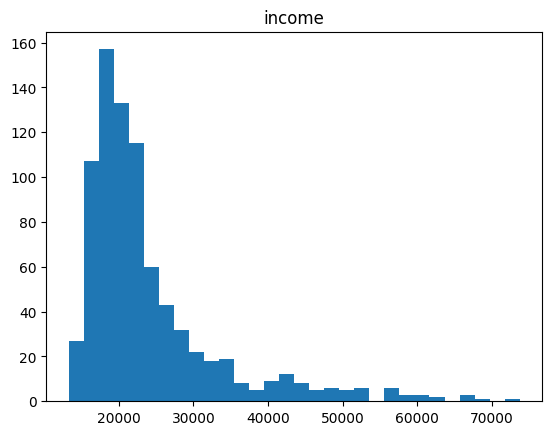

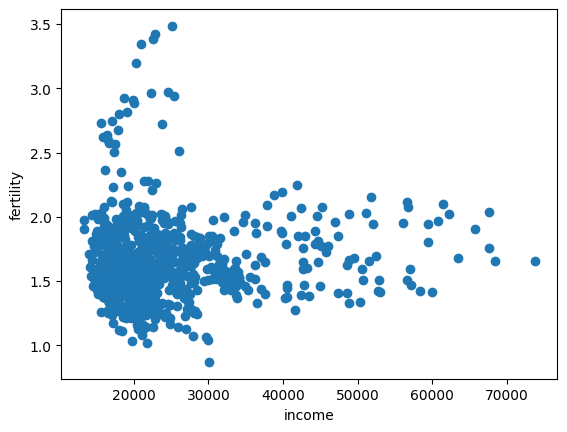

In [160]:
EDA(new_df, 'income')

Ситуация с безработицей похожа: она распределена неравномерно и имеет большой разброс. Однако, в отличие от зарплат, наблюдается более сильная положительная связь с рождаемостью

count    816.000000
mean       6.324632
std        3.981351
min        1.200000
25%        4.200000
50%        5.300000
75%        7.000000
max       43.700000
Name: unemployment, dtype: float64


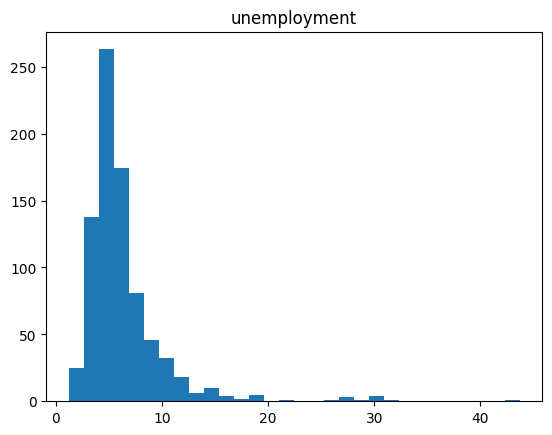

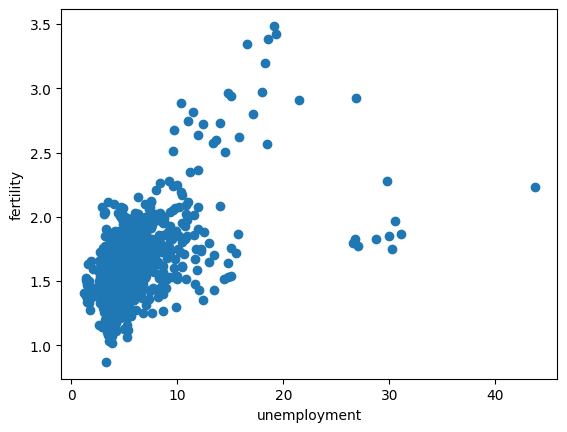

In [161]:
EDA(new_df, 'unemployment')

In [ ]:
Бедность имеет больший разброс - гистограмма более сплюснута. Диаграмма рассеяния 
также свидетельствует о положительной взаимосвязи с рождаемостью

count    816.000000
mean       0.143952
std        0.050045
min        0.045007
25%        0.110300
50%        0.139342
75%        0.168554
max        0.359337
Name: poverty, dtype: float64


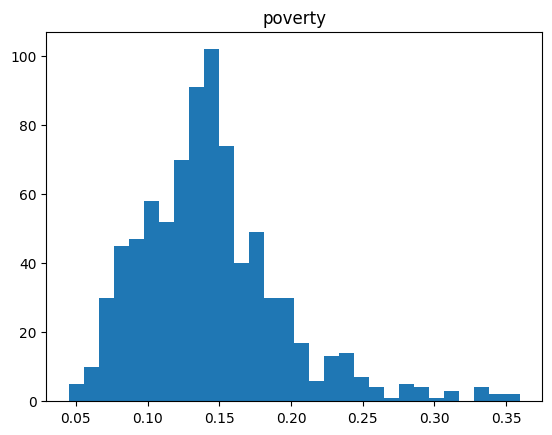

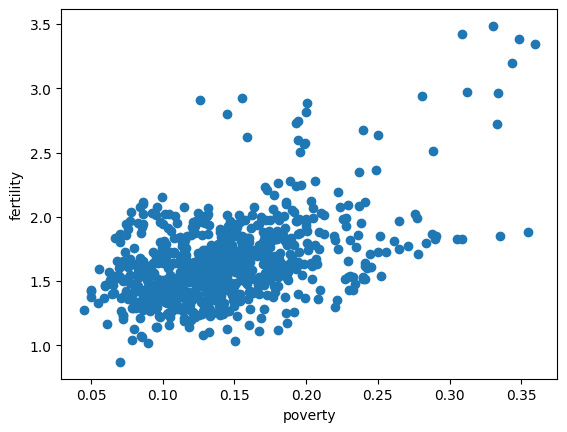

In [162]:
EDA(new_df, 'poverty')

Рождаемость имеет меньший разброс. Гистрограммы четырех показателей очень похожи - они имеют характерный пик и чем-то напоминают нормальное распереление.

count    816.000000
mean       1.648604
std        0.322276
min        0.871000
25%        1.444000
50%        1.599500
75%        1.803000
max        3.485000
Name: fertility, dtype: float64


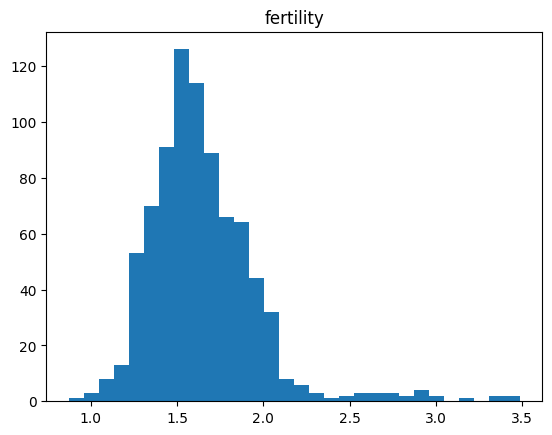

In [163]:
EDA(new_df, 'fertility')

Как видно из матрицы корреляции, между рождаемостью и бедностью, а также между рождаемостью и безработицей наблюдается значимая положительная связь.

In [164]:
new_df.corr()

,income,unemployment,fertility,poverty
income,1.000000,-0.225619,0.046948,-0.322596
unemployment,-0.225619,1.000000,0.529356,0.621222
fertility,0.046948,0.529356,1.000000,0.489319
poverty,-0.322596,0.621222,0.489319,1.000000


    Анализ показал, что рождаемость действительно может иметь связь с бедностью и безработицей, однако ее связь с зарплатой довольно незначительна. Возможно, стоит рассматривать не столько сами зарплаты, сколько их динамику по годам. 
    Также как качественный фактор стоит уделить внимание регионам, в которых находятся субъекты (Центральный, Южный итд).